In [3]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.transpiler import CouplingMap

from gate_level.spillover_noise_use_case.generic_spillover.generic_spillover_noise import (
    numpy_to_hashable,
)
from generic_spillover_noise import (
    circuit_context,
    noisy_backend,
    SpilloverNoiseAerPass,
)
from rl_qoc import (
    ContextAwareQuantumEnvironment,
    QiskitConfig,
    QEnvConfig,
    ExecutionConfig,
)
import matplotlib.pyplot as plt

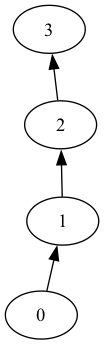

In [4]:
# Define the number of qubits
num_qubits = 4
cm = CouplingMap.from_line(num_qubits, False)
cm.draw()

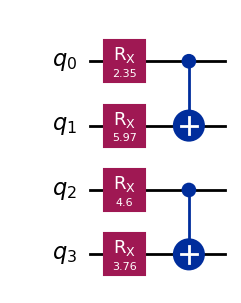

In [5]:
# Define parameters for U(phi) gates
# phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
n_layers = 1
seed = 42
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, size=num_qubits * n_layers)
rotation_axes = ["rx"] * num_qubits
from qiskit.circuit.library import n_local

qc = circuit_context(
    num_qubits, rotation_axes, ParameterVector("θ", num_qubits), coupling_map=cm
)
qc = qc.assign_parameters(rotation_angles, inplace=False)
qc.draw("mpl")

In [6]:
print(qc.data)

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[2.353304971691044]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[5.9735141613602165]), qubits=(Qubit(QuantumRegister(4, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[4.599253580133889]), qubits=(Qubit(QuantumRegister(4, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.761482191925223]), qubits=(Qubit(QuantumRegister(4, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumReg

Text(0.5, 1.0, 'Spillover rate matrix')

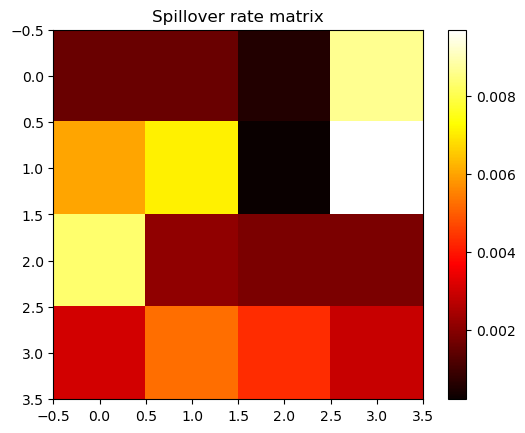

In [7]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
# gamma_matrix[0, 1] = 0.000  # γ_0->1
# gamma_matrix[0, 3] = 0.0  # γ_0->3
# gamma_matrix[1, 2] = 0.001  # γ_1->2
# gamma_matrix[2, 1] = 0.001  # γ_2->1
# gamma_matrix[2, 2] = 0.0
# gamma_matrix[2, 3] = 0.01  # γ_2->3
# gamma_matrix[3, 2] = 0.0  # γ_3->2
# gamma_matrix[4, 3] = 0.0  # γ_4->3
# gamma_matrix[5, 4] = 0.0  # γ_5->4
gamma_matrix = 0.01 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [8]:
# Create the noisy backend tailored for spillover noise
backend = noisy_backend(qc, gamma_matrix, coupling_map=cm)
backend.operation_names

['h',
 'break_loop',
 'save_superop',
 'ry',
 'unitary',
 'save_stabilizer',
 'save_state',
 'save_expval',
 'x',
 'while_loop',
 'quantum_channel',
 'qerror_loc',
 'save_amplitudes',
 'save_density_matrix',
 'save_statevector_dict',
 'set_unitary',
 'continue_loop',
 'z',
 'reset',
 'for_loop',
 'rzx',
 'save_clifford',
 'set_stabilizer',
 'set_superop',
 'switch_case',
 'measure',
 'roerror',
 'set_statevector',
 'u',
 'save_probabilities_dict',
 'set_matrix_product_state',
 'superop',
 'if_else',
 'save_expval_var',
 'rx',
 'save_unitary',
 'kraus',
 'save_amplitudes_sq',
 'save_probabilities',
 'initialize',
 'set_density_matrix',
 'delay',
 'rz',
 'cx',
 'save_statevector',
 's',
 'sdg',
 'save_matrix_product_state']

In [7]:
from qiskit.transpiler import PassManager, generate_preset_pass_manager
from qiskit.transpiler.passes import UnrollForLoops

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
pm.translation.append(
    SpilloverNoiseAerPass(spillover_rate_matrix=numpy_to_hashable(gamma_matrix))
)
# pm.translation.append(UnrollForLoops())

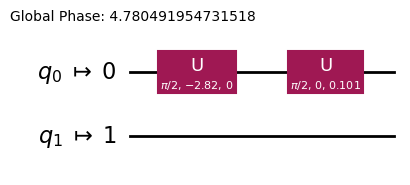

In [8]:
noisy_qc = pm.run(qc)
noisy_qc.draw("mpl")

In [9]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '18ee4b07f50347bca8f3ae0cf8ca0311',
   'operations': ['rx(2.35, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[ 9.99938070e-01+0.j        ,  0.00000000e+00-0.00861278j,
                0.00000000e+00-0.00704783j, -6.07051269e-05-0.j        ],
              [ 0.00000000e+00-0.00861278j,  9.99938070e-01+0.j        ,
               -6.07051269e-05-0.j        ,  0.00000000e+00-0.00704783j],
              [ 0.00000000e+00-0.00704783j, -6.07051269e-05-0.j        ,
                9.99938070e-01+0.j        ,  0.00000000e+00-0.00861278j],
              [-6.07051269e-05-0.j        ,  0.00000000e+00-0.00704783j,
                0.00000000e+00-0.00861278j,  9.99938070e-01+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': '1f5dcbf44546489782a3d39f67f28b76',
   'operations': ['rx(5.97, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],


In [10]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]
    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [11]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc.environment import RescaleAndClipAction

action_space = Box(low=-1, high=1, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    pass_manager=pm,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=64,
        n_reps=[3, 5],
        n_shots=50,
        sampling_paulis=100,
    ),
    reward="channel",
)
q_env = ContextAwareQuantumEnvironment(q_env_config, circuit_context=qc)
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

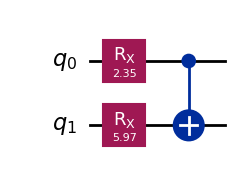

In [12]:
q_env.get_target(0).causal_cone_circuit.draw("mpl")

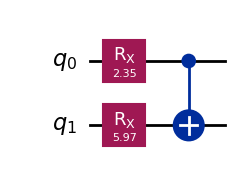

In [13]:
q_env.circuit_context.draw("mpl")

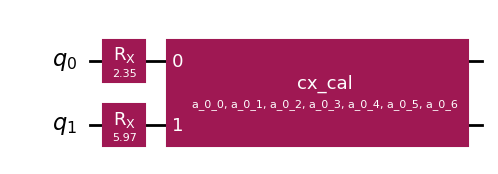

In [14]:
q_env.circuits[0].draw("mpl")

In [ ]:
from rl_qoc.rewards.real_time import get_real_time_reward_circuit

pub = get_real_time_reward_circuit(
    q_env.circuits[0],
    q_env.target,
    q_env.backend_info,
    q_env.config.execution_config,
    q_env.config.reward.reward_method,
)
pub.draw(
    "mpl",
    scale=1,
    vertical_compression="medium",
    expr_len=5,
    justify="right",
    initial_state=True,
    with_layout=False,
    fold=30,
)

In [ ]:
from qiskit.qasm3 import Exporter

exporter = Exporter((), basis_gates=["h", "sdg", "x", "rzx", "u"])

In [17]:
print(exporter.dumps(pub))

OPENQASM 3.0;
input float[64] a_0_0;
input float[64] a_0_1;
input float[64] a_0_2;
input float[64] a_0_3;
input float[64] a_0_4;
input float[64] a_0_5;
input float[64] a_0_6;
input uint[4] input_state_1;
input uint[4] observable_0;
input uint[4] input_state_0;
input uint[4] observable_1;
input uint[8] n_reps;
gate u3(p0, p1, p2) _gate_q_0 {
  u(p0, p1, p2) _gate_q_0;
}
gate u1(p0) _gate_q_0 {
  u3(0, 0, p0) _gate_q_0;
}
gate s _gate_q_0 {
  u1(pi/2) _gate_q_0;
}
gate r(p0, p1) _gate_q_0 {
  u3(p0, p1 - pi/2, pi/2 - p1) _gate_q_0;
}
gate rx(p0) _gate_q_0 {
  r(p0, 0) _gate_q_0;
}
bit[2] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
int switch_dummy_3;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x $0;
  }
  case 2 {
    h $0;
  }
  case 3 {
    h $0;
    s $0;
  }
}
switch_dummy_0 = input_state_1;
switch (switch_dummy_0) {
  case 0 {
  }
  case 1 {
    x $1;
  }
  case 2 {
    h $1;
  }
  case 3 {
    h $1;
   

In [26]:
for var in pub.iter_input_vars():
    print(var.name)
    print(var.type.kind)

observable_0
<class 'qiskit.circuit.classical.types.types.Uint'>
observable_1
<class 'qiskit.circuit.classical.types.types.Uint'>
n_reps
<class 'qiskit.circuit.classical.types.types.Uint'>
input_state_0
<class 'qiskit.circuit.classical.types.types.Uint'>
input_state_1
<class 'qiskit.circuit.classical.types.types.Uint'>


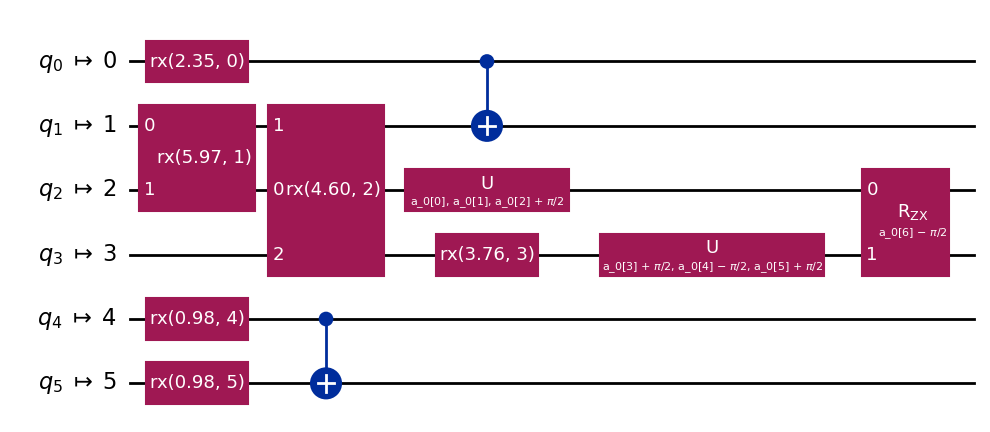

In [15]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [16]:
from rl_qoc.agent import PPOConfig

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
agent_config = PPOConfig.from_yaml(file_name)
print(agent_config)

PPOConfig(run_name='spillover_subsystem', num_updates=1, n_epochs=8, learning_rate=0.0005, gamma=0.99, gae_lambda=0.95, clip_ratio=0.2, clip_value_loss=True, clip_value_coef=0.2, normalize_advantage=True, entropy_coef=0.01, value_loss_coef=0.5, gradient_clip=0.5, include_critic=True, hidden_layers=[64, 64], hidden_activation_functions=[Tanh(), Tanh()], input_activation_function=Identity(), output_activation_mean=Tanh(), output_activation_std=Sigmoid(), optimizer=<class 'torch.optim.adam.Adam'>, minibatch_size=16, checkpoint_dir='tmp/ppo', training_config=TrainingConfig(training_constraint=TotalUpdates(total_updates=250), target_fidelities=[0.999, 0.9999, 0.99999], lookback_window=10, anneal_learning_rate=False, std_actions_eps=0.01), train_function_settings=TrainFunctionSettings(plot_real_time=False, print_debug=False, num_prints=10, hpo_mode=False, clear_history=False, save_data=False), wandb_config=WandBConfig(enabled=True, project='GateCalibration', entity=None, tags=None, notes=Non

In [17]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 500
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

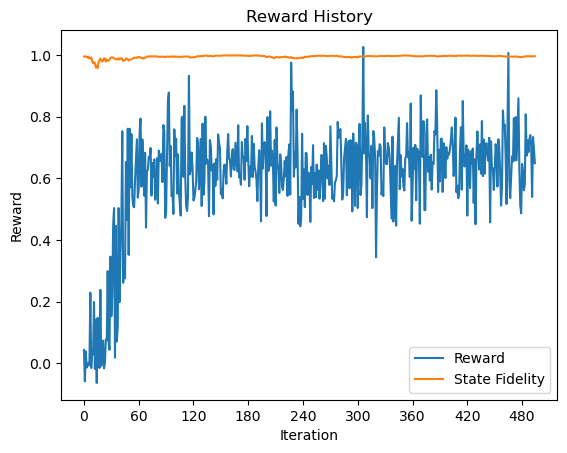


 Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9964592648516961
Sending Estimator job...
Time for running 2.243467092514038 seconds
Finished Estimator job
Reward (avg): 0.5995722223816015 Std: 0.037155727108680855

 Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.99663698559402
Sending Estimator job...
Time for running 4.053233861923218 seconds
Finished Estimator job
Reward (avg): 0.5746109359470036 Std: 0.0319390555894646

 Number of repetitions: 8
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9969261297477683
Sending Estimator job...
Time for running 5.192248106002808 seconds
Finished Estimator job
Reward (avg): 0.584512040074108 Std: 0.05808156048934603

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9971153650319582
Sending Estimator job...
Time for running 5.774698972702026 

{'avg_reward': [0.04286265574958377,
  -0.059033346236301285,
  0.038385653833147584,
  -0.014263618088214147,
  -0.010151685582098044,
  0.0009738382131411027,
  -0.005824825142993139,
  0.22874793718555847,
  -0.015869602448222976,
  0.04197264598786885,
  0.028050742507852958,
  0.19854642502260483,
  -0.018687551191540416,
  0.14145753634414915,
  -0.06421370327840842,
  0.1472738848597388,
  0.056412364004874205,
  -0.01578083879112489,
  0.23777245212959214,
  -0.00842514541479155,
  0.042551000050234045,
  0.07302655706011142,
  -0.01701816207214632,
  0.0023523680075350304,
  0.07670235634678073,
  0.07487972648813151,
  0.29893810487753514,
  0.0703970874752605,
  0.043445395638289364,
  0.3457894340091505,
  0.1522631523820332,
  0.2183687299336266,
  0.4475619837487945,
  0.5032377717235591,
  0.017852403998082474,
  0.44569209465875537,
  0.07026766917245783,
  0.11701731837888601,
  0.5032989938902421,
  0.19790025609206496,
  0.35498666177140126,
  0.46279973665804397,
  

<Figure size 640x480 with 0 Axes>

In [18]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

In [28]:
q_env.observables

SparsePauliOp(['IIIIII', 'IIXIII', 'IIYIII', 'IIYIII', 'IIZIII', 'IIZIII', 'IIZIII', 'IIIXII', 'IIXXII', 'IIYXII', 'IIYXII', 'IIZXII', 'IIZXII', 'IIZXII', 'IIZXII', 'IIIYII', 'IIIYII', 'IIXYII', 'IIXYII', 'IIYYII', 'IIYYII', 'IIYYII', 'IIZYII', 'IIZYII', 'IIZYII', 'IIIZII', 'IIIZII', 'IIIZII', 'IIXZII', 'IIXZII', 'IIXZII', 'IIYZII', 'IIYZII', 'IIZZII', 'IIZZII'],
              coeffs=[ 0.25      +0.j,  0.25      +0.j, -0.51863532+0.j,  0.32927446+0.j,
 -0.32927446+0.j, -0.51863532+0.j, -0.67724969+0.j,  0.25      +0.j,
  0.25      +0.j,  0.32927446+0.j, -1.06672595+0.j,  1.06672595+0.j,
 -0.67724969+0.j, -0.32927446+0.j, -0.51863532+0.j,  0.38854814+0.j,
  0.457407  +0.j, -0.72045498+0.j,  0.457407  +0.j, -0.75018957+0.j,
 -0.42937644+0.j,  0.36473736+0.j, -0.36473736+0.j,  0.88313884+0.j,
 -0.42937644+0.j, -0.457407  +0.j,  0.38854814+0.j,  0.61199642+0.j,
  0.38854814+0.j, -0.72045498+0.j,  0.457407  +0.j, -0.36473736+0.j,
 -0.42937644+0.j,  0.42937644+0.j, -0.36473736+0.j])

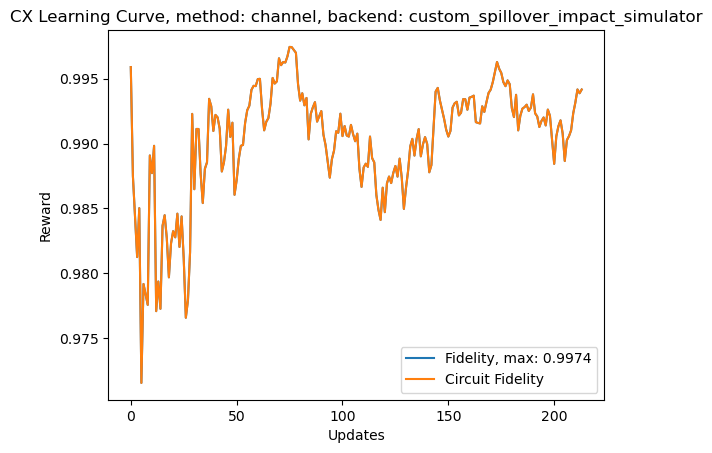

In [20]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
# plt.plot(
#     q_env.circuit_fidelity_history_nreps,
#     label=f"Circuit Fidelity nreps(={q_env.n_reps})",
# )
# plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

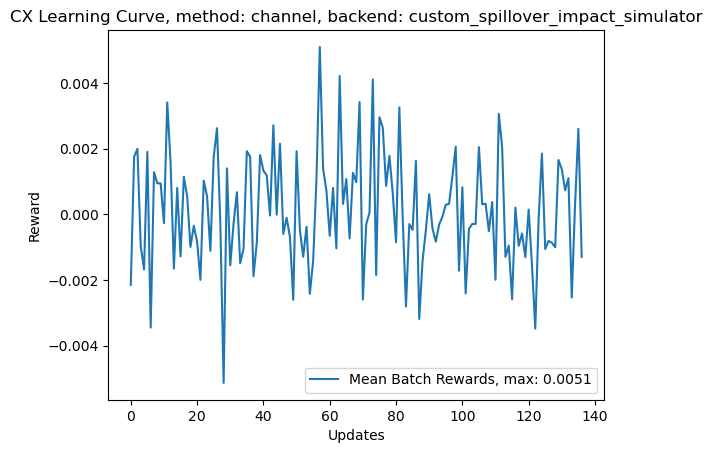

In [20]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
# plt.plot(
#     q_env.fidelity_history,
#     label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
# )
# plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
# plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
# plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [33]:
q_env.optimal_action

array([ 0.16718724, -0.1882672 , -0.16773811, -0.2       ,  0.02085974,
       -0.14108044,  0.2       ], dtype=float32)

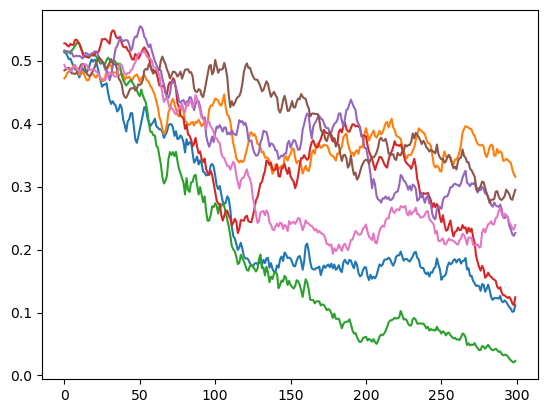

In [35]:
plt.plot(ppo_agent.training_results["std_action"])

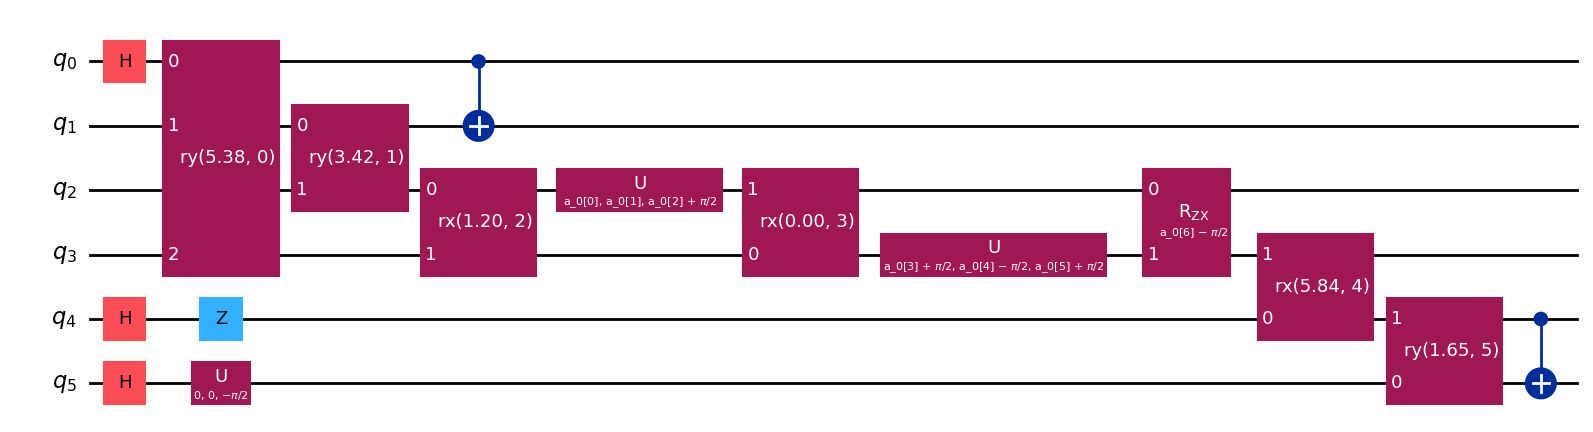

In [37]:
q_env._pubs[0][0].draw("mpl")

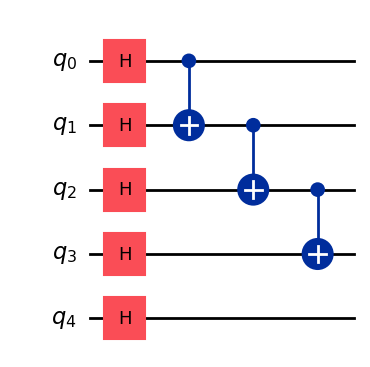

In [2]:
from qiskit.circuit import QuantumCircuit
from rl_qoc.helpers.transpiler_passes import CustomGateReplacementPass
from qiskit.transpiler import PassManager

qc = QuantumCircuit(5)
qc.h(range(5))
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.draw("mpl")

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_90893/1674038932.py:7: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  dag_to_circuit(pass_.run(circuit_to_dag(qc))).draw("mpl")
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_90893/1674038932.py:7: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  dag_to_circuit(pass_.run(circuit_to_dag(qc))).draw("mpl")


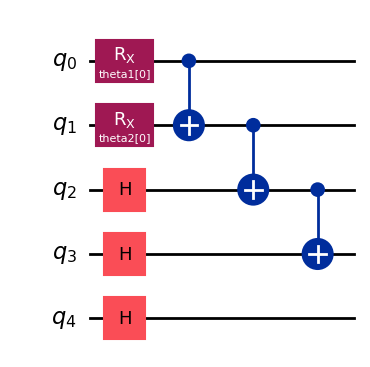

In [6]:
from qiskit.circuit import ParameterVector
from qiskit.converters import circuit_to_dag, dag_to_circuit


def custom_gate(qc, params, qregs):
    qc.rx(params[0], qregs[0])


pass_ = CustomGateReplacementPass(
    [("h", (0,)), ("h", (1,))],
    [custom_gate, custom_gate],
    [ParameterVector("theta1", 1), ParameterVector("theta2", 1)],
)
pm = PassManager([pass_])
dag_to_circuit(pass_.run(circuit_to_dag(qc))).draw("mpl")

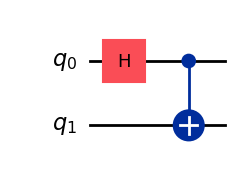

In [17]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

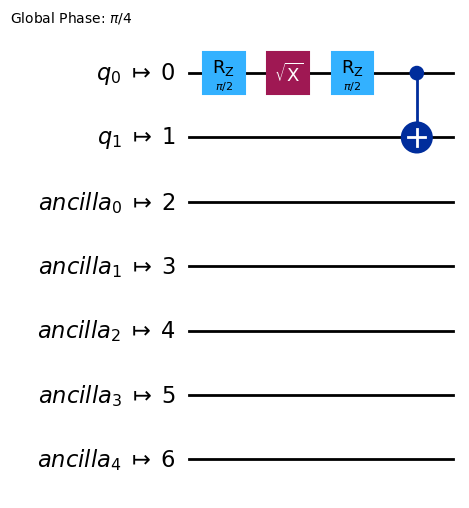

In [19]:
from qiskit import pulse, transpile, schedule
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2

backend = FakeJakartaV2()
qc2 = transpile(qc, backend, initial_layout=[0, 1])
qc2.draw("mpl")

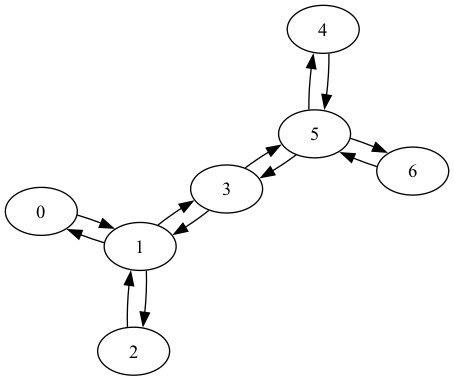

In [20]:
backend.coupling_map.draw()

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_72033/1760764288.py:1: DeprecationWarning: The function ``qiskit.compiler.scheduler.schedule()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that ``qiskit.compiler.scheduler.schedule()`` will be moved as well.
  sched = schedule(qc2, backend)


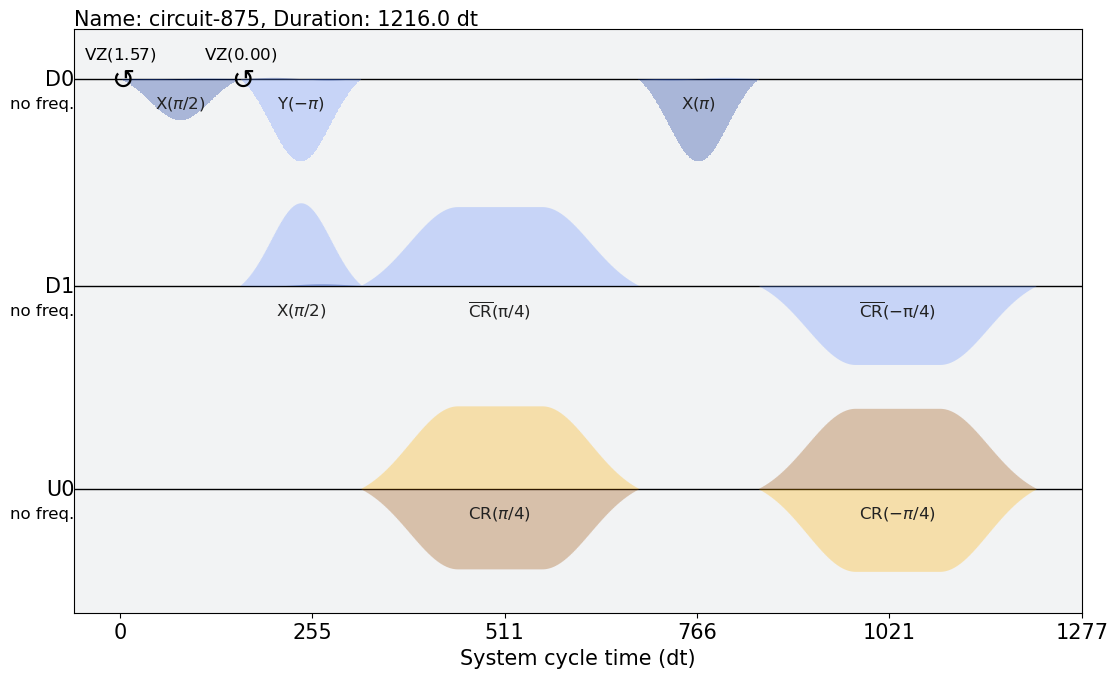

In [21]:
sched = schedule(qc2, backend)
sched.draw()

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_72033/3636248165.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend) as sched:
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_72033/3636248165.py:4: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(pulse.Gaussian(duration=20, amp= amp, sigma=20), pulse.DriveChannel(0))
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_72033/3636248165.py:4: DeprecationWarning: The function ``qiskit.pulse.builder

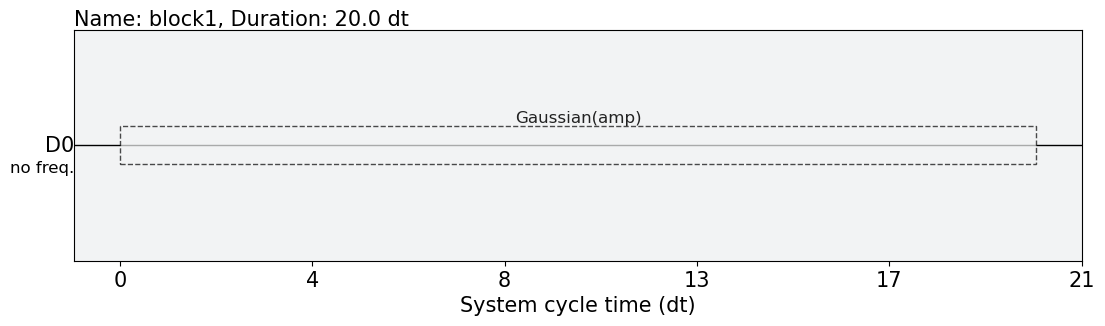

In [23]:
from qiskit.circuit import Parameter

amp = Parameter("amp")
with pulse.build(backend) as sched:
    pulse.play(pulse.Gaussian(duration=20, amp=amp, sigma=20), pulse.DriveChannel(0))
sched.draw()

In [ ]:
qc.add_calibration(
    "rx",
    [
        0,
    ],
    sched,
)

In [3]:
import gzip
import pickle


def load_data_from_gzip_pickle(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data


data = load_data_from_gzip_pickle(
    "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/gate_level/spillover_noise_use_case/generic_spillover/gate_calibration_cx-gate_physical_qubits_0-1_TotalUpdates(total_updates=10)_CAFE-reward_input_states_choice-pauli4_fidelity-0.90126_timestamp_21-02-2025_02-33-44.pickle"
)

In [4]:
data

[{'trial_number': 0,
  'training_results': {'avg_reward': [0.281640625,
    0.348046875,
    0.319921875,
    0.330078125,
    0.304296875,
    0.326953125,
    0.3953125,
    0.369921875,
    0.27890625,
    0.3831912878787878,
    0.27961647727272726,
    0.284564393939394,
    0.3331439393939393,
    0.27502367424242424,
    0.3103693181818182,
    0.38650568181818185,
    0.37599431818181817,
    0.3328125],
   'fidelity_history': [0.8853756898832165,
    0.9012599940009419,
    0.8978820129755324,
    0.8862849808643242,
    0.8666423063394777,
    0.8712537956114577,
    0.8637543260937758,
    0.8469899930680331,
    0.8524750403969256,
    0.8508541881866065,
    0.8292402479221271,
    0.8406099265756215,
    0.8492863445932018,
    0.8500560598718254,
    0.8585205607957812,
    0.8347936244596624,
    0.8184161026664711,
    0.8061051560517726],
   'hardware_runtime': [],
   'total_shots': [2560,
    2560,
    2560,
    2560,
    2560,
    2560,
    2560,
    2560,
    2560,

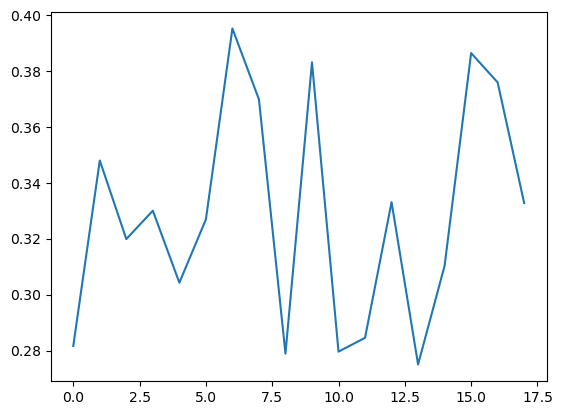

In [6]:
import matplotlib.pyplot as plt

plt.plot(data[0]["training_results"]["avg_reward"])